In [45]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import numpy as np
from scipy.special import gamma
from scipy import signal
from scipy import stats
import time
try:
    from tqdm import tqdm_notebooks as tqdm
except ImportError:
    tqdm = lambda x: x
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
###

from scipy.stats import pearsonr, zscore
from MFDFA import fgn
# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()
from tqdm import tqdm


import matplotlib as mpl
from matplotlib import cm

import sys
sys.path.insert(0, '/directory/tothe/handshakefile/')

from shogun import *
from scipy.stats import norm, laplace
import random
import hypothesisTesting.shogunMMDutils as mmdutils
import hypothesisTesting.kernel2sampletest as k2st

# import stylised_facts_data_utilities.createLOB as createLOB
import stylised_facts_data_utilities.gpyNARX as gpyNARX
import stylised_facts_data_utilities.longtaildistr as longtail
%matplotlib inline

plt.style.use(os.path.join(mpl.get_configdir(),'latexstyle.mplstyle'))

In [2]:
def shogun_features(x, y):
    # create shogun features
    return [RealFeatures(x.reshape(1, len(x))), RealFeatures(y.reshape(1, len(y)))]

In [3]:
# import numerical libraries

from scipy import stats
# import tableone
try:
    from tableone import TableOne
except (ModuleNotFoundError, ImportError):
    # install on Colab
    !pip install tableone
    from tableone import TableOne

### Assumptions and Investigations

1/ By moving to the tick domain, the need to force each trade into a time slot is removed as one does
not need to force the trades into predetermined sampling points as in calendar time. Additionally, when using calendar time sampling

2/ can we recover normality in each of the assets and periods?

3/duration between trades is
also added to the subordination framework to account for
the speed with which market participants act in physical
time.

4/we bring qualitative empirical evidence that the impact of a single
trade depends on the intertrade time lags. We find that when the trading rate be- comes faster, the return variance per trade strongly increases and that this behavior persists at coarser time scales. 

5/So we answer the following question: is the realized variance created by 10 trades arriving over 10 seconds similar to the realized variance created by those very same trades had they arrived during 10 minutes? Any model that uses a transaction time clock implies that the two situations are similar. Our empirical findings show that they are not, and that trades arriving in a shorter duration have higher variance, thus showing the importance of the physical inter-trade time duration. 

In [4]:
ActivityCLockData= '/media/ak/My Passport/Experiment Data/ActivityClockData/'
OHLCData= '/media/ak/My Passport/Experiment Data/OHLCData/'
folderList = os.listdir(ActivityCLockData)
OHLCDataList = os.listdir(OHLCData)
ActivityClockDataList = os.listdir(ActivityCLockData)

symbols =['FB1','JB1','FV1','G_1','DU1']

In [5]:
JB1ClocksData = np.sort([s for s in os.listdir(ActivityCLockData) if 'Clocks' in s and ('JB1') in s])

In [6]:
DU1ClocksData = np.sort([s for s in os.listdir(ActivityCLockData) if 'Clocks' in s and ('DU1') in s])

In [8]:
pickle.load(open(pklClockFile , "rb")).keys()

dict_keys(['OriginalDF', 'TickBarDf', 'VolumeBarDf', 'DollarVolumeBarDf'])

## pick DU1 First ## 

In [9]:
# for pklidx in range(0,15):  
volumeBarDictCondensedDU1 = dict()
for pklidx in range(0,25): 
    pklClockFile = "".join((ActivityCLockData,DU1ClocksData[pklidx]))
    volumeBarDF = pickle.load(open(pklClockFile , "rb"))['VolumeBarDf']
    volumeBarDF['MicroPriceChange'] = tickBarDF.MicroPrice.pct_change()
#     print(tickBarDF.head(3))
    volumeBarDictCondensedDU1[DU1ClocksData[pklidx].split('_')[3]]=tickBarDF 

In [71]:
graphicsLocation = '/home/ak/Documents/Research/Papers/StylisedFactsPaper/figures'

## steps ##

In [12]:
# keep track of the keys
keysDU1 = list(tickBarDictCondensedDU1.keys()) 
# concatenate all the data
allDU1 =pd.concat(list(tickBarDictCondensedDU1.values() ), axis =0, keys = list(tickBarDictCondensedDU1.keys()))


In [13]:
medianMicroPrice_DU1 = allDU1.median(level=1).MicroPriceChange.dropna()
medianMicroPrice_DU1_acrossDays = allDU1.median(level=0).MicroPrice.dropna()
# produce medians across time 

In [57]:
# kick out the tails
DU1medianMPChange =k2st.SeriesBetweenPercentiles(series= medianMicroPrice_DU1 , upperValue= 95, lowerValue=5)


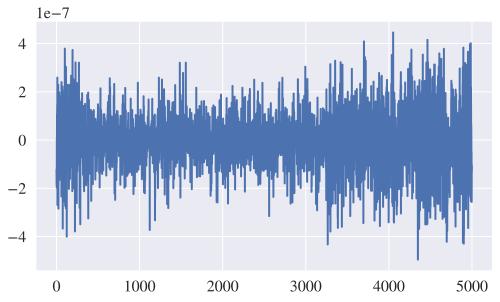

In [58]:
# take out one sample
du1sample = signal.resample(DU1medianMPChange, 5000)
plt.plot(du1sample)
plt.show()

In [59]:
mu = np.average(DU1medianMPChange)
sigma2 = np.var(DU1medianMPChange)
print(mu, sigma2)
normalDU1=norm.rvs(size=n, loc=mu, scale=sigma2)

-4.2668124382575967e-10 1.4820392249150107e-14


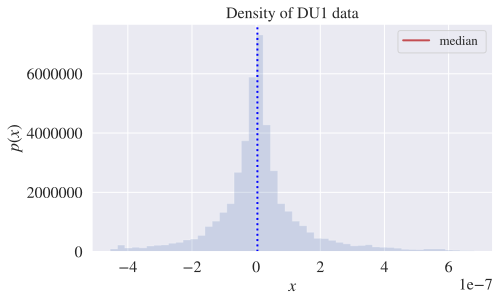

In [49]:
# generate a normal distribution using the same 
fig, ax = plt.subplots(1, 1)
n= 5000
# calculate pdf over a range of values
xx = np.arange(np.min(DU1medianMPChange), np.max(DU1medianMPChange), 0.001)
yy = stats.norm.pdf(xx)
plt.hist(DU1medianMPChange, density=True, histtype='stepfilled', alpha=0.2, bins=50)

plt.plot(xx, yy, 'r',lw=2)
_=plt.legend([ 'median '])
plt.axvline(x=np.percentile(du1sample, 50), c='blue',linestyle = 'dotted')
plt.show()

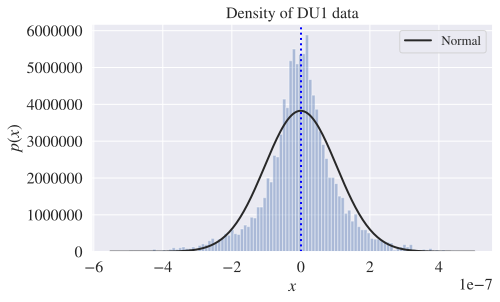

In [72]:
ax = sns.distplot(du1sample, kde=False, fit=stats.norm, bins=100)
xx = np.arange(np.min(DU1medianMPChange), np.max(DU1medianMPChange), 0.001)
yy = stats.norm.pdf(xx)
plt.title("Density of DU1 data")
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
_=plt.legend([ 'Normal'])
plt.axvline(x=np.percentile(du1sample, 50), c='blue',linestyle = 'dotted')
title= 'VolumeClockNormalFit'+'DU1'+'.png'
plt.savefig(os.path.join(graphicsLocation,title))

In [73]:
from statsmodels.graphics.gofplots import qqplot


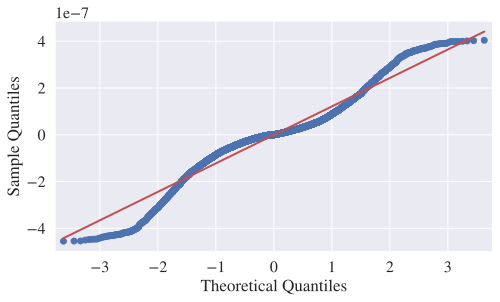

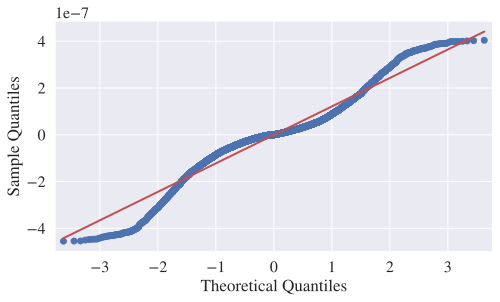

In [75]:
qqplot(DU1medianMPChange, line='s')

## pick FB1 second ##

In [10]:
# symbol_choice_2='FB1'
# FB1ClocksData = np.sort([s for s in os.listdir(ActivityCLockData) if 'Clocks' in s and (symbol_choice_2) in s])
# pklidx=1
# tickBarDictCondensedFB1 = dict()
# for pklidx in range(0,25):
#     pklClockFile = "".join((ActivityCLockData,FB1ClocksData[pklidx]))
#     tickBarDF =pickle.load(open(pklClockFile , "rb"))['TickBarDf'] #tickbar
#     tickBarDF['MicroPriceChange'] = tickBarDF.MicroPrice.pct_change()
#     tickBarDictCondensedFB1[FB1ClocksData[pklidx].split('_')[3]]=tickBarDF [['BidSize', 'QuoteTime','BestBid',
#        'TradeTime', 'AskSize','BestAsk', 'TradeVolume', 'TradedTime', 'type',
#        'TradePrice', 'TimeStamp', 'milliSeconds','DollarVolume', 'MicroPrice', 'MicroPriceChange','TradeSize', 'DollarVolumeTraded']]


In [ ]:
                           
keysFB1 = list(tickBarDictCondensedFB1.keys())

## concatenate all the dictionaries into one 

In [ ]:


allFB1 =pd.concat(list(tickBarDictCondensedFB1.values() ), axis =0, keys = list(tickBarDictCondensedFB1.keys()))


#### write a piece of code that essentially looks at returns across all the clocks and then assesses normality of returns. do we recover normality using different clocks?

### compute median prices properly

In [ ]:

medianMicroPrice_FB1 = allFB1.median(level=1).MicroPriceChange.dropna()

In [ ]:

medianMicroPrice_FB1_acrossDays = allFB1.median(level=0).MicroPrice.dropna()

In [ ]:

plt.plot(medianMicroPrice_FB1)


## remove extremities 

In [ ]:
def SeriesBetweenPercentiles(series, upperValue,lowerValue):
    # Find out percentiles and get values in between
    lThres = np.percentile(series , lowerValue) # lower percentile
    uThres = np.percentile(series , upperValue) # higher percentile
    return series[(series > lThres) & (series <uThres)]

In [ ]:
FB1medianMPChange =SeriesBetweenPercentiles(series= medianMicroPrice_FB1 , upperValue= 95, lowerValue=5)

In [ ]:
fig, ax = plt.subplots(1, 1)
symbol_choice= 'DU1'
plt.hist(DU1medianMPChange, color='grey', density=True, histtype='stepfilled', alpha=0.3, bins=30)
plt.axvline(x=np.percentile(DU1medianMPChange, 50), c='red',linestyle = 'dotted')
legend = [symbol_choice+" 50% quantile"]
ax.legend(loc='best', frameon=False)
ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.title("Densities of microprice returns")
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
plt.legend(legend, loc='best')
title= 'DensityMicroPrice'+str(symbol_choice)+'.png'
plt.savefig(os.path.join(graphicsLocation,title))

In [ ]:
du1sample = signal.resample(DU1medianMPChange, 1000)
fb1sample = signal.resample(FB1medianMPChange, 1000)

In [ ]:
feat_p, feat_q = shogun_features(fb1sample,du1sample)
mmdInstance = mmdutils.SignificanceResultsMMD(fb1sample,du1sample)

In [ ]:
feat_p_2, feat_q_2 = mmdInstance.shogun_features(fb1sample,du1sample)
# this function needs re-writing?

## unit-testing my functionality next

In [ ]:
mmd = QuadraticTimeMMD(feat_p_2, feat_q_2)

mmd_2 = mmdInstance.mmd()

In [ ]:
mmd.set_statistic_type(ST_BIASED_FULL)
kernel = GaussianKernel(10, 1)
mmd.set_kernel(kernel)
mmd.compute_statistic()

In [ ]:
kernel = GaussianKernel(10, 1)
mmd.set_kernel(kernel)
kernel1 = GaussianKernel(10, 0.1)
kernel2 = GaussianKernel(10, 1)
kernel3 = GaussianKernel(10, 10)
kernel4 = GaussianKernel(5, 0.15)
mmd.add_kernel(kernel1)
mmd.add_kernel(kernel2)
mmd.add_kernel(kernel3)
mmd.add_kernel(kernel4)

mmd.set_train_test_mode(True)
mmd.set_train_test_ratio(1)

In [ ]:
kernel_2 = GaussianKernel(20, 1)
mmd_2.set_kernel(kernel)
kernel1 = GaussianKernel(10, 0.1)
kernel2 = GaussianKernel(10, 1)
kernel3 = GaussianKernel(10, 10)
kernel4 = GaussianKernel(5, 0.15)
mmd_2.add_kernel(kernel1)
mmd_2.add_kernel(kernel2)
mmd_2.add_kernel(kernel3)
mmd_2.add_kernel(kernel4)

mmd_2.set_train_test_mode(True)
mmd_2.set_train_test_ratio(1)

In [ ]:
num_runs = 1
num_folds = 3
alpha = 0.05
mmd_2.set_kernel_selection_strategy(KSM_CROSS_VALIDATION, num_runs, num_folds, alpha)
mmd_2.select_kernel()
learnt_kernel_single = GaussianKernel.obtain_from_generic(mmd_2.get_kernel())
width = learnt_kernel_single.get_width()
print('Print best kernel width is:', width)


_, p_value_biased = mmdInstance.compute_the_p_value_biased(mmd=mmd_2, kernel=learnt_kernel_single)
_, p_value_unbiased = mmdInstance.compute_the_p_value_unbiased(mmd=mmd_2, kernel=learnt_kernel_single)


# mmdutils.SignificanceResultsMMD.test_by_hand(mmd=mmd_2, p_value=p_value_unbiased, alpha=alpha)
# mmdutils.SignificanceResultsMMD.full_two_sample(mmd=mmd_2, alpha=alpha)



In [ ]:
num_runs = 200
p_values = np.zeros(num_runs)

last = time.time()
for i in range(num_runs):
    feats_p, feats_q = shogun_features(fb1sample,jb1sample)
    width=1
    k = GaussianKernel(10, width)

    mmd = QuadraticTimeMMD()
    mmd.set_p(feats_p)
    mmd.set_q(feats_q)
    mmd.set_kernel(k)

    mmd.set_num_null_samples(50)
    stat = mmd.compute_statistic() # would be good if compute_p_value() with no arguments computed the statistic itself
    p_values[i] = mmd.compute_p_value(stat)

# does this look more or less uniform (it has to be)?
plt.hist(p_values);

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.distplot(p_values, bins =50,color = "blue")
plt.axvline(x=np.percentile(p_values, 50), c='red',linestyle = 'dotted')
legend = ["median $p-$ value"]
ax.legend(loc='best', frameon=False)
_=plt.title("Distribution of $p$-values")
_=plt.xlabel("$x$")
title= 'DistributionPvaluesJB1DU1.png'
plt.savefig(os.path.join(graphicsLocation,title))




In [ ]:
from scipy.spatial.distance import squareform, pdist, cdist

def sq_distances(X,Y=None):
    """
    If Y=None, then this computes the distance between X and itself
    """
    assert(X.ndim==2)

    # IMPLEMENT: compute pairwise distance matrix. Don't use explicit loops, but the above scipy functions
    # if X=Y, use more efficient pdist call which exploits symmetry
    if Y is None:
        sq_dists = squareform(pdist(X, 'sqeuclidean'))
    else:
        assert(Y.ndim==2)
        assert(X.shape[1]==Y.shape[1])
        sq_dists = cdist(X, Y, 'sqeuclidean')

    return sq_dists
def gauss_kernel(X, Y=None, sigma=1.0):
    """
    Computes the standard Gaussian kernel k(x,y)=exp(- ||x-y||**2 / (2 * sigma**2))

    X - 2d array, samples on left hand side
    Y - 2d array, samples on right hand side, can be None in which case they are replaced by X
    
    returns: kernel matrix
    """

    # IMPLEMENT: compute squared distances and kernel matrix
    sq_dists = sq_distances(X,Y)
    K = np.exp(-sq_dists / (2 * sigma**2))
    return K

# IMPLEMENT
def linear_kernel(X, Y):
    return np.dot(X, Y.T)
def quadratic_time_mmd(X,Y,kernel):
    assert X.ndim == Y.ndim == 2
    K_XX = kernel(X,X)
    K_XY = kernel(X,Y)
    K_YY = kernel(Y,Y)
       
    n = len(K_XX)
    m = len(K_YY)
    
    # IMPLEMENT: unbiased MMD statistic (could also use biased, doesn't matter if we use permutation tests)
    np.fill_diagonal(K_XX, 0)
    np.fill_diagonal(K_YY, 0)
    mmd = np.sum(K_XX) / (n*(n-1))  + np.sum(K_YY) / (m*(m-1))  - 2*np.sum(K_XY)/(n*m)
    return mmd
def two_sample_permutation_test(test_statistic, X, Y, num_permutations, prog_bar=True):
    assert X.ndim == Y.ndim
    
    statistics = np.zeros(num_permutations)
    
    range_ = range(num_permutations)
    for i in range_:
        # concatenate samples
        if X.ndim == 1:
            Z = np.hstack((X,Y))
        elif X.ndim == 2:
            Z = np.vstack((X,Y))
            
        # IMPLEMENT: permute samples and compute test statistic
        perm_inds = np.random.permutation(len(Z))
        Z = Z[perm_inds]
        X_ = Z[:len(X)]
        Y_ = Z[len(X):]
        my_test_statistic = test_statistic(X_, Y_)
        statistics[i] = my_test_statistic
    return statistics
def plot_permutation_samples(null_samples, statistic=None, title=None):
    #plt.hist(
    sns.distplot(null_samples, bins=50, color='grey')
    plt.axvline(x=np.percentile(null_samples, 2.5), c='b')
    legend = ["95% quantiles"]
    if statistic is not None:
        plt.axvline(x=statistic, c='r', linewidth=3, linestyle='--')
        legend += ["Actual test statistic"]
    plt.legend(legend, loc='best')
    plt.axvline(x=np.percentile(null_samples, 97.5), c='b')
    plt.xlabel("Test statistic value")
    plt.ylabel("Counts")
    if title is not None:
        plt.savefig(os.path.join(graphicsLocation,title))

In [ ]:
X, Y = (fb1sample,jb1sample)
my_kernel = lambda X,Y : gauss_kernel(X,Y,sigma=0.2)
my_mmd = lambda X,Y : quadratic_time_mmd(X[:,np.newaxis],Y[:,np.newaxis], my_kernel)
num_permutations = 200
statistics = two_sample_permutation_test(my_mmd, X, Y, num_permutations)
my_statistic = my_mmd(X,Y)

In [ ]:
grid = np.linspace(np.min(X), np.max(X))
bins=150
my_kernel = lambda X,Y : gauss_kernel(X,Y, sigma=0.5)
#sns.distplot(X, bins =bins, color = "skyblue", label ="FB1")
sns.distplot(Y, bins =bins,color = "red", label ="JB1")
# plt.title("Witness function")
# # IMPLEMENT: evaluate MMD witness function on grid
# phi_X = np.mean(my_kernel(X[:,np.newaxis], grid[:,np.newaxis]), axis=0)
# phi_Y = np.mean(my_kernel(Y[:,np.newaxis], grid[:,np.newaxis]), axis=0)
# witness = phi_X-phi_Y
# plt.xlabel("$x$")
# plt.ylabel("$p(x)$")
# _=plt.legend([ 'FB1','JB1'])
# plt.plot(grid, witness, linestyle ='--')